# Foundations of Computer Vision: Applied Projects


This Jupyter notebook series contains the bases of the laboratories you need to develop during the semester.

The main goal of those projects is twofold: 1st is to reiterate the theoretical context of the lectures and 2nd to use those methods in adapted examples for real-world scenarios.

## Import libraries, util functions and test image loading



Libraries that you can use (not mandatory) and some auxiliar functions that could be useful on this block.

In [138]:
import cv2
import urllib3
import numpy as np

from PIL import Image

import imutils
from matplotlib import pyplot as plt


In [9]:
def add_noise(image, noise_type, mean=0, std=0.01, amount=0.05, salt=0.5):
    """
    Add noise to an image.

    Parameters:
    - image: numpy array of shape (H, W) for grayscale or (H, W, 3) for RGB
    - noise_type: string, one of 'gaussian', 'salt_pepper', 'speckle'
    - params: dictionary containing parameters specific to the noise type

    Returns:
    - noisy_image: numpy array with added noise
    """

    if noise_type == 'gaussian':
        sigma = std**0.5
        noise = np.random.normal(mean, sigma, image.shape).astype(image.dtype)
        noisy_image = cv2.add(image, noise)

    elif noise_type == 'salt_pepper':
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * salt)
        coords = [np.random.randint(0, i-1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount*image.size*(1. - salt))
        coords = [np.random.randint(0, i-1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        noisy_image = out

    elif noise_type == 'speckle':
        noise = np.random.randn(*image.shape).astype(image.dtype)
        noisy_image = image + image * noise

    else:
        raise ValueError(f"Noise type '{noise_type}' is not supported.")

    # Clip values to be in [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

def add_periodic_noise(image, frequency=5, amplitude=10):
    X, Y = np.meshgrid(np.arange(image.shape[0]),np.arange(image.shape[1]))

    noise = amplitude * np.sin(2 * np.pi * frequency * Y / image.shape[0])

    noisy_image = image + noise

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image


# Block 1. Linear filtering
This block focuses on linear filtering, one of the foundational concepts in image processing and computer vision. We'll be delving deep into how convolution operates, the distinction between convolution and correlation, and the magic of the Fourier transform in image filtering.

### Objectives:

1. **Implement and Learn How Convolution Works:**  
   A self-implemented convolution function and its application on sample images.

2. **Use Convolution to Apply Linear Filters:**  
   Blurred and edge-detected versions of input images using your convolution function.

3. **Compare Convolution and Correlation:**  
   Implementation of correlation function and comparison with convolution.

4. **Normalized Cross-Correlation and Use for Template Matching:**  
   Function to locate a template within a larger image.

5. **Fourier Transform and Image Filtering:**  
   Filtered images emphasizing or de-emphasizing certain frequency components.

---

### Mandatory Questions:

- What is the purpose of image filtering in computer vision? Can you list some common applications?

- Why do we often use odd-sized kernels in image filtering? When we want to use even-sized filters?

- Why do we often use a flipped version of the kernel in the convolution operation?

- What is the fundamental difference between convolution and correlation? Can you demonstrate this with an example?

- How does changing the size of the kernel affect the outcome of the convolution operation?

- Explain the process of convolution and how it is used to apply a filter to an image.

- In your own words, explain the significance of the Fourier transform in image processing.

- Describe the process and the underlying principle of template matching using normalized cross-correlation.

- Why might one choose to operate in the frequency domain (using Fourier transform) instead of the spatial domain when processing an image?

- Can we remove "salt and pepper" noise with some of those linear filters?  


### Optional Deep Dive Questions:

- Besides convolution, what are other methods to apply filters to an image? Can you compare and contrast these methods?

- Explore the concept of separable kernels. What benefits do they provide in convolution?

- What is the purpose of the padding in the convolution operation, and what are the different types of padding? Explain also the purpose of stride and how this affects the output?

- Explain which types of filters might be important for a real-scenario application (e.g., self-driving car vision system, medical image analysis).

- What are the limitations of linear filters when it comes to noise reduction? Are there scenarios where they might not be ideal?

- How would might you extend the concepts of convolution to color images? Which complexities arise when dealing with multiple channels?

- Fourier transform is used in various fields outside of image processing. Can you find and explain an application outside of computer vision?

- Explore and explain the difference between the discrete Fourier transform (DFT) and the fast Fourier transform (FFT). Why might FFT be preferred in many applications?


## Convolution operation



#### Objective:
Implement the convolution operation by hand and compare it with standard library functions. Also, manipulate image sizes through upsampling and downsampling using convolution. The focus will be on handling edge cases and experimenting with various kernels.

---

#### Guideline:
1. Implement a function to perform the convolution operation on an image. Make sure to handle edge cases and allow for different kernel sizes. DO NOT USE LIBRARY IMPLEMENTATIONS.
2. Develop methods for upsampling and downsampling images using your convolution function.
3. Experiment with your convolution function by applying different kernels on various images.
4. Compare your hand-implemented convolution outcomes with standard library methods such as OpenCV's `filter2d` and SciPy's `convolve`.

---

#### Expected results:
- Your hand-implemented convolution, upsampling, and downsampling code.
- Resized images at scales: (2x, 0.5x).

(398, 398)
(398, 398)


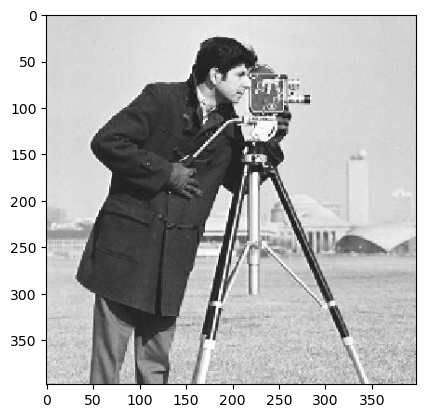

In [147]:
from typing import Union, Any, Iterable

def convolution(image: Union[np.ndarray, Any], kernel: np.ndarray, stride: int = 1, padding: Union[int, Iterable] = 0):
	# manage arguments
	if not isinstance(image, np.ndarray):
		try:
			image = np.array(image)
		except:
			raise TypeError('Invalid image type')
	if isinstance(padding, int):
		padding = (padding, padding)
	elif not isinstance(padding, Iterable):
		raise TypeError('padding must be int or an iterable of 2 ints')
	# flip kernel
	kernel = np.flip(kernel)
	# image padding
	h, w = image.shape # image size
	new_h = (h - kernel.shape[0] + 2*padding[0]) // stride + 1
	new_w = (w - kernel.shape[1] + 2*padding[1]) // stride + 1
	p_y, p_x = padding
	image_padded = np.pad(image, ((p_y, p_y), (p_x, p_x)), 'constant')
	result = np.zeros((new_h, new_w))

	# convolution
	for i in range(0, new_h):
		for j in range(0, new_w):
			temp = image_padded[i*stride:i*stride+kernel.shape[0], j*stride:j*stride+kernel.shape[1]]
			result[i][j] = np.sum(temp * kernel) # element-wise multiplication
	
	return result


def gaussian_kernel(size: int, sigma: Union[int, float]):
	# The kernel's size is the image size divided by two
	width, height = size
	width = (width - 1) / 2
	height = (height - 1) / 2
	# The coordinates for the 2 dimensions (we use a multi-dimensional mesh grid in correspondance to the size of the kernel) centered around zero
	x, y = np.mgrid[-width:width+1, -height:height+1]
	# Use gaussian formula to compute gaussian kernel (mean of gaussian filter is 0 (centered in 0) so we can ignore it)
	normal = 1 / (2.0 * np.pi * sigma**2) 
	g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
	return g


def upscale_image(image: Union[np.ndarray, Any], scale_factor: Union[int, float]):
	if isinstance(scale_factor, float) and scale_factor < 1:
		return downscale_image(image, 1 / scale_factor)
	# img = np.repeat(image, scale_factor, axis=0) # repeat each row scale_factor times, so intermediate pixels are duplicates of the previous ones
	# img = np.repeat(img, scale_factor, axis=1) # same for columns
	return img

def downscale_image(image, scale_factor):
	if isinstance(scale_factor, float) and scale_factor < 1:
		return downscale_image(image, 1 / scale_factor)
	kernel = np.ones((scale_factor, scale_factor)) / scale_factor**2
	image_downscaled = convolution(image, kernel, stride=scale_factor, padding=0)
	return image_downscaled

# Load images and test your functions
image = cv2.imread('images/cameraman.png', cv2.IMREAD_GRAYSCALE)
kernel = np.array([
	[1, 1, 1],
	[1, 1, 1],
	[1, 1, 1]
])

# kernel = gaussian_kernel((15, 15), 5)
# plt.imshow(kernel, cmap='gray')
p = ((kernel.shape[0] - 1) // 2, (kernel.shape[1] - 1) // 2)
print(image.shape)
# img = convolution(image, kernel, stride=1, padding=p)
img = downscale_image(image, 1)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

## Linear Filtering


#### Objective:
Explore various image filtering techniques by applying them to a set of example images as well as images of your own choice. Experiment with different kernel sizes and types of filters to observe their effects.

- Blur:
  - Average Box Filter
  - Gaussian Filter
- Edge:
  - Laplacian Filter
  - Sobel Filter
  - Prewitt Filter

Feel free to experiment with additional filters as well.

---

#### Guideline:
1. Apply each of the given filters to the example images provided.
2. Use images of your own choosing to further experiment with these filters.
3. Experiment with varying kernel sizes for each filter.
4. Analyze the effects of each filter and kernel size on the images.

---

#### Expected results:
- Filtered images (both example and your own)
- Analysis of the effect of kernel size


Examples of different linear filters for blur and edge *detection*

1. **Average Box Filter:**
   ```
   1/9  1/9  1/9
   1/9  1/9  1/9
   1/9  1/9  1/9
   ```

2. **Gaussian Blur Filter:**
   ```
   1/16  2/16  1/16
   2/16  4/16  2/16
   1/16  2/16  1/16
   ```

3. **Laplacian Filter:**
   ```
   0  1  0
   1 -4  1
   0  1  0
   ```

4. **Sobel Operator (horizontal || vertical):**
   ```
     -1  0  1  ||  -1 -2 -1
     -2  0  2  ||   0  0  0
     -1  0  1  ||   1  2  1
  ```

5. **Prewitt Operator (horizontal || vertical):**
   ```
    -1  0  1  || -1 -1 -1
    -1  0  1  ||  0  0  0
    -1  0  1  ||  1  1  1
   ```



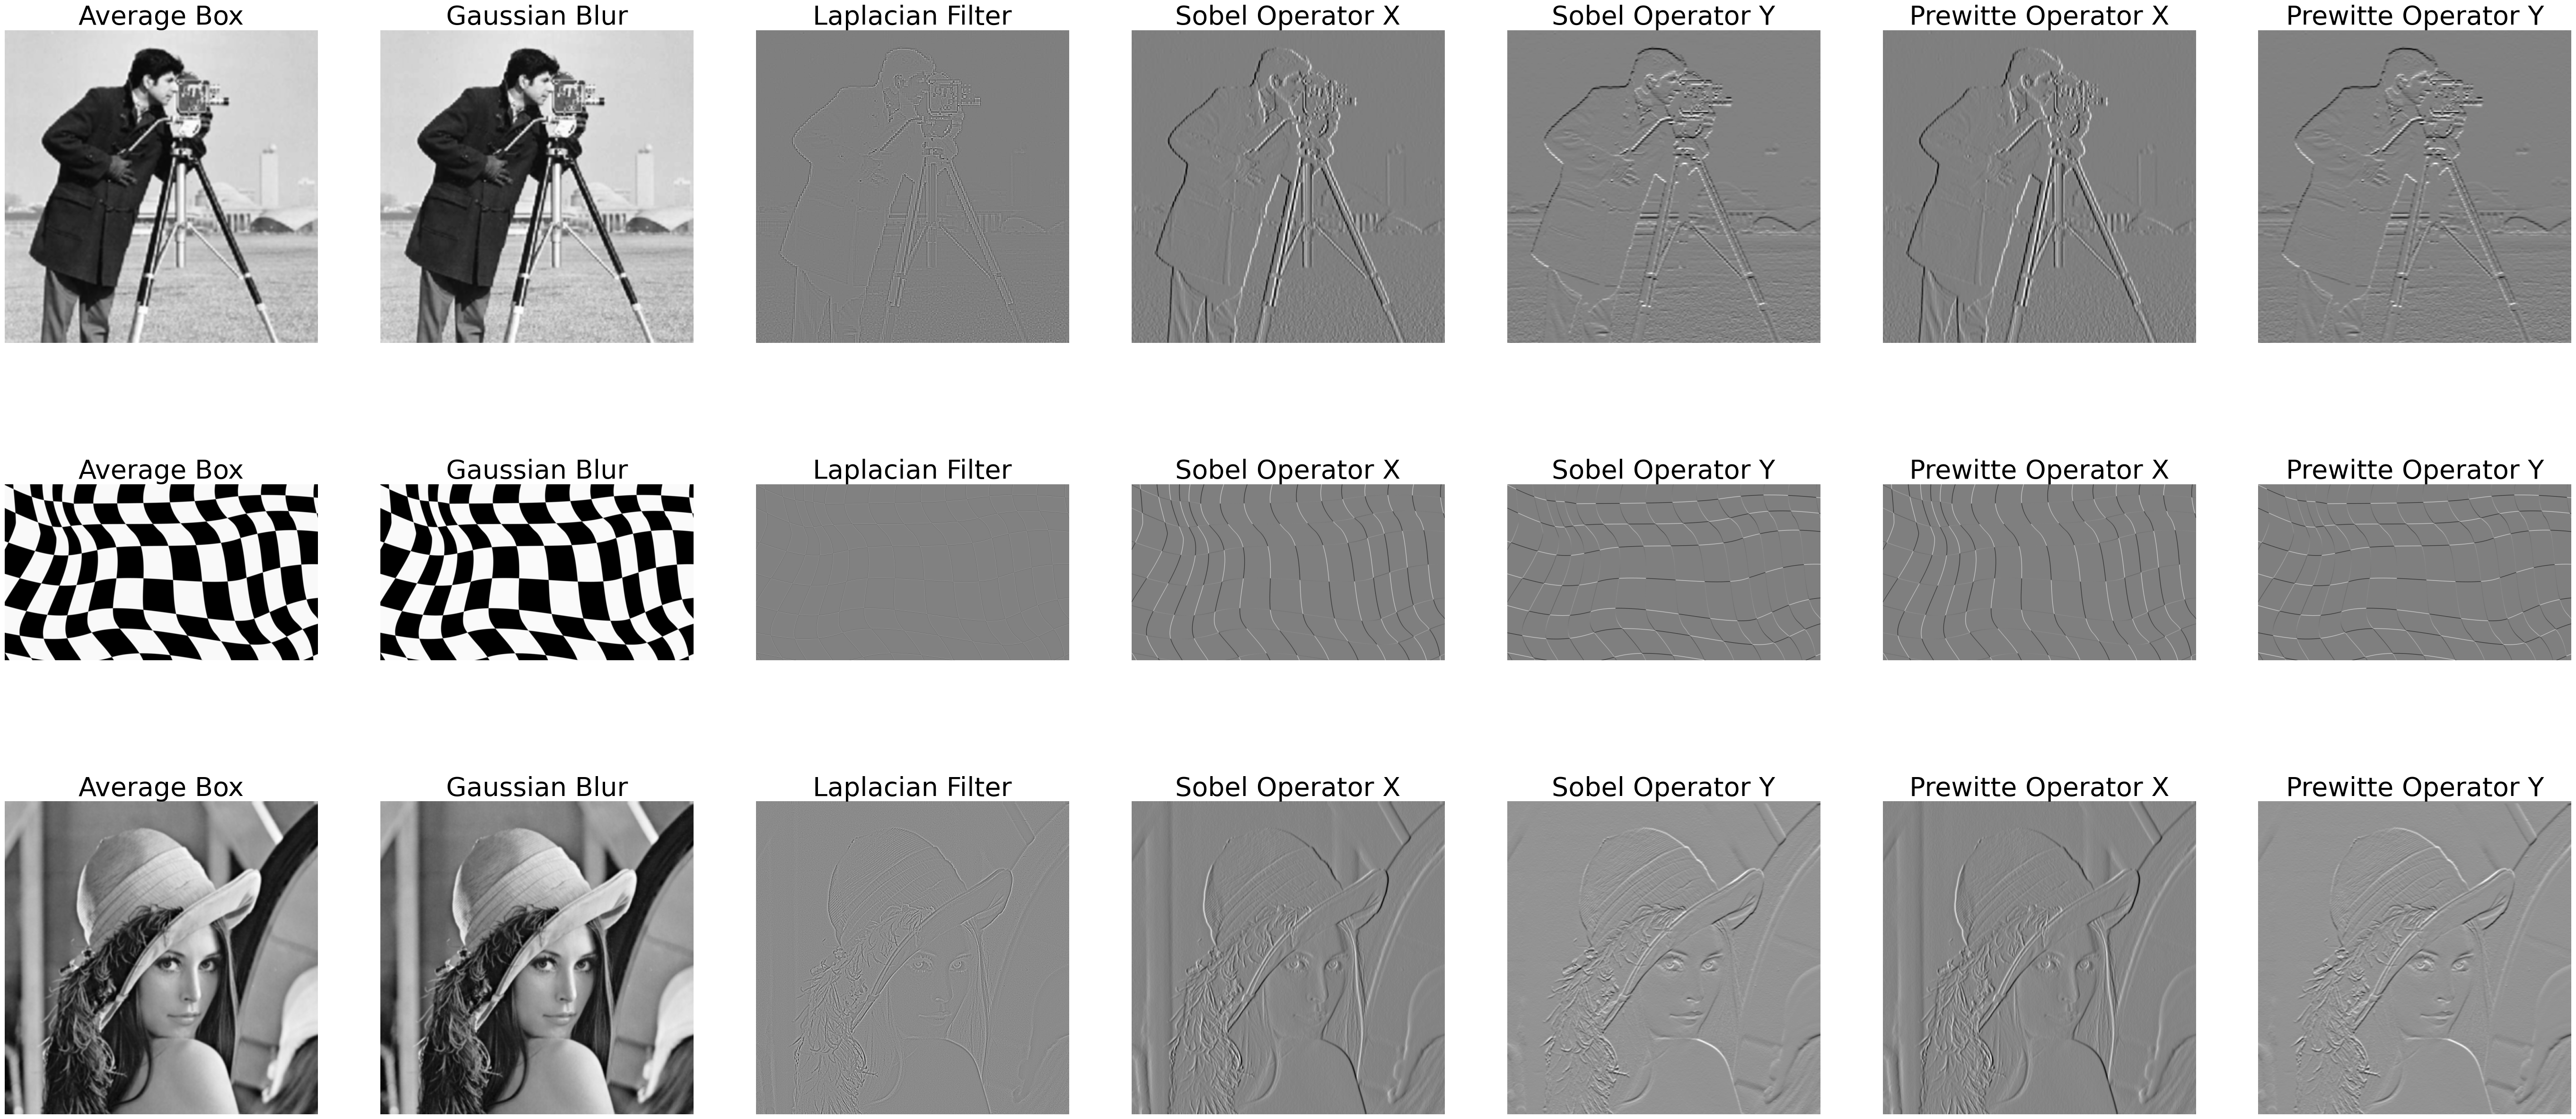

In [154]:
from scipy.signal import convolve2d

def apply_linear_filter(image, kernel):
	# manage arguments
	if not isinstance(image, np.ndarray):
		try:
			image = np.array(image)
		except:
			raise TypeError('Invalid image type')
	padding = (0, 0)
	# image padding
	h, w = image.shape # image size
	new_h = (h - kernel.shape[0] + 2*padding[0]) // 1 + 1
	new_w = (w - kernel.shape[1] + 2*padding[1]) // 1 + 1
	p_y, p_x = padding
	image_padded = np.pad(image, ((p_y, p_y), (p_x, p_x)), 'constant')
	result = np.zeros((new_h, new_w))

	# convolution
	for i in range(0, new_h):
		for j in range(0, new_w):
			temp = image_padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
			result[i][j] = np.sum(temp * kernel) # element-wise multiplication
	
	return result

average_box = np.ones((3, 3)) / 9
gaussian_blur = np.array([
	[1/16, 2/16, 1/16],
	[2/16, 4/16, 2/16],
	[1/16, 2/16, 1/16]
])

laplacian_filter = np.array([0, 1, 0, 1, -4, 1, 0, 1, 0]).reshape(3, 3)
sobel_operator_x = np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape(3, 3)
sobel_operator_y = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape(3, 3)

prewitte_operator_x = np.array([-1, 0, 1, -1, 0, 1, -1, 0, 1]).reshape(3, 3)
prewitte_operator_y = np.array([-1, -1, -1, 0, 0, 0, 1, 1, 1]).reshape(3, 3)

image1 = cv2.imread('images/cameraman.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('images/distorted_checkers.jpg', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('images/lenna.png', cv2.IMREAD_GRAYSCALE)
filter_names = ['Average Box', 'Gaussian Blur', 'Laplacian Filter', 'Sobel Operator X', 'Sobel Operator Y', 'Prewitte Operator X', 'Prewitte Operator Y']
filters = [average_box, gaussian_blur, laplacian_filter, sobel_operator_x, sobel_operator_y, prewitte_operator_x, prewitte_operator_y]
images = [image1, image2, image3]
plt.figure(figsize=(10*len(filters), 10*len(images)))
for i, image in enumerate(images):
	for f, filter in enumerate(filters):
		plt.subplot(len(images), len(filters), f + i*len(filters) + 1)
		img = apply_linear_filter(image, filter)
		plt.imshow(img, cmap='gray')
		plt.axis('off')
		plt.title(filter_names[f], fontsize=40)

## Template matching


#### **Objective:**
Implement template matching system using normalized cross-correlations (NCC). You need to identify multiple templates within a given image and draw bounding boxes around the identified regions.

---

#### Guidelines:
1. Implement the normalized cross-correlation algorithm. Your function should accept an image and a template as parameters. DO NOT USE LIBRARIES.
3. Use a folder containing multiple templates to attempt to identify all templates within a given test image.
4. Draw bounding boxes around the identified template regions in the test image.
---

#### Expected result:
- A test image with bounding boxes around identified templates

## Fourier Transform



#### **Objective**:
You are provided with three images, each corrupted by one or more periodic frequencies. Your task is to process these images using Fourier Transform techniques to identify and remove the corrupting frequencies.

- Image 1 has one specific corrupting frequency.
- Image 2 has another unique corrupting frequency.
- Image 3 has both frequencies from Image 1 and Image 2.

---

#### Guideline:
1. Use Fourier Transform to convert each image to the frequency domain. (you can use libraries for this)
2. Analyze the Fourier spectrum to identify the corrupting frequencies.
3. Remove the identified frequencies and perform an Inverse Fourier Transform to obtain the cleaned image.
4. Compare the cleaned images with the original corrupted ones and quantify the improvements.

---
#### Expected results:
- Cleaned images
